In [216]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import pyro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyro.distributions as dist


sns.set(style="white", context="notebook", palette="deep", color_codes=True)

In [ ]:
# TODO: I don't think this toy example is rich enough. Can I change it to be a linear model with changing parameters?

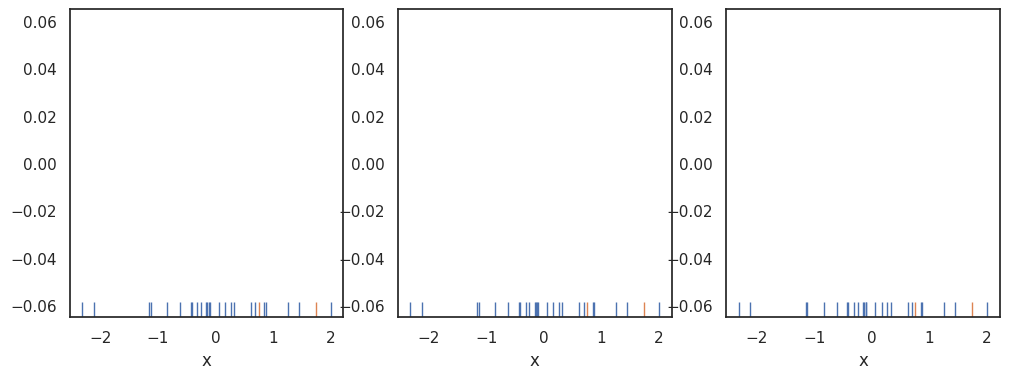

In [217]:
# Generate a bunch of samples from a normal distribution
torch.manual_seed(0)
pyro.set_rng_seed(0)
N_nominal = 25
N_failure = 2
nominal_mean = 0.0
failure_mean = 1.0
std = 1.0

nominal_samples = torch.normal(nominal_mean, std, (N_nominal,))
failure_samples = torch.normal(failure_mean, std, (N_failure,))

df = pd.concat(
    [
        pd.DataFrame({"x": nominal_samples, "type": "nominal"}),
        pd.DataFrame({"x": failure_samples, "type": "failure"}),
    ]
)

fig, axs = plt.subplot_mosaic([["failure_only", "all_data", "gavi"]], figsize=(12, 4))

for ax in axs.values():
    sns.rugplot(x="x", hue="type", data=df, ax=ax, legend=False, height=0.05)

In [218]:
# Define the toy model
def original_model(n_samples, x=None):
    mean = pyro.sample("mean", dist.Normal(0.0, 10.0))
    sigma = torch.exp(pyro.sample("log_std", dist.Normal(0.0, 10.0)))

    with pyro.plate("data", n_samples):
        return pyro.sample("x", dist.Normal(mean, sigma), obs=x)

In [219]:
pyro.clear_param_store()

# These should be reset each training loop.
nominal_auto_guide = pyro.infer.autoguide.AutoNormal(original_model)
elbo_ = pyro.infer.Trace_ELBO()
elbo = elbo_(original_model, nominal_auto_guide)
elbo(N_nominal, nominal_samples)
optim = torch.optim.Adam(elbo.parameters(), lr=0.02)

losses = []
for step in range(500):
    optim.zero_grad()
    loss = elbo(N_nominal, nominal_samples)
    loss.backward()
    optim.step()
    losses.append(loss.detach())

n_posterior_samples = 100_000
with pyro.plate("samples", n_posterior_samples, dim=-1):
    nominal_posterior_samples = nominal_auto_guide(N_nominal)

pyro.clear_param_store()

# These should be reset each training loop.
failure_auto_guide = pyro.infer.autoguide.AutoNormal(original_model)
elbo_ = pyro.infer.Trace_ELBO()
elbo = elbo_(original_model, failure_auto_guide)
elbo(N_nominal, nominal_samples)
optim = torch.optim.Adam(elbo.parameters(), lr=0.02)

losses = []
for step in range(500):
    optim.zero_grad()
    loss = elbo(N_failure, failure_samples)
    loss.backward()
    optim.step()
    losses.append(loss.detach())

with pyro.plate("samples", n_posterior_samples, dim=-1):
    failure_posterior_samples = failure_auto_guide(N_failure)

failure_only_posterior_df = pd.concat(
    [
        pd.DataFrame(
            {
                "x": nominal_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Nominal",
            }
        ),
        pd.DataFrame(
            {
                "x": failure_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Failure",
            }
        ),
    ]
)

In [220]:
pyro.clear_param_store()

# These should be reset each training loop.
all_auto_guide = pyro.infer.autoguide.AutoNormal(original_model)
elbo_ = pyro.infer.Trace_ELBO()
elbo = elbo_(original_model, all_auto_guide)
elbo(N_nominal, nominal_samples)
optim = torch.optim.Adam(elbo.parameters(), lr=0.02)

losses = []
for step in range(500):
    optim.zero_grad()
    loss = elbo(N_nominal + N_failure, torch.concat([nominal_samples, failure_samples]))
    loss.backward()
    optim.step()
    losses.append(loss.detach())

with pyro.plate("samples", n_posterior_samples, dim=-1):
    all_posterior_samples = all_auto_guide(N_failure)

all_posterior_df = pd.concat(
    [
        pd.DataFrame(
            {
                "x": nominal_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Nominal",
            }
        ),
        pd.DataFrame(
            {
                "x": all_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Failure",
            }
        ),
    ]
)

In [221]:
mean_loc = nominal_auto_guide.locs.mean.item()
mean_scale = nominal_auto_guide.scales.mean.item()

log_std_loc = nominal_auto_guide.locs.log_std.item()
log_std_scale = nominal_auto_guide.scales.log_std.item()

print(f"mean: loc {mean_loc} scale {mean_scale}")
print(f"log_std: loc {log_std_loc} scale {log_std_scale}")

def updated_model(n_samples, x=None):
    mean = pyro.sample("mean", dist.Normal(mean_loc, mean_scale))
    sigma = torch.exp(pyro.sample("log_std", dist.Normal(log_std_loc, log_std_scale)))

    with pyro.plate("data", n_samples):
        return pyro.sample("x", dist.Normal(mean, sigma), obs=x)

mean: loc -0.05797036737203598 scale 0.1832912564277649
log_std: loc 0.06819075345993042 scale 0.14689978957176208


In [222]:
graduated_auto_guide = pyro.infer.autoguide.AutoNormal(original_model)
elbo_ = pyro.infer.Trace_ELBO()
elbo = elbo_(original_model, graduated_auto_guide)
elbo(N_nominal, nominal_samples)
optim = torch.optim.Adam(elbo.parameters(), lr=0.02)

gavi_samples = {}
graduations = torch.linspace(0.0, 1.0, 10)
graduations = graduations.tolist()
for graduation in graduations:
    for step in range(500):
        optim.zero_grad()
        loss = (1 - graduation) * elbo(N_nominal, nominal_samples) + elbo(
            N_failure, failure_samples
        )
        loss.backward()
        optim.step()

    with pyro.plate("samples", n_posterior_samples, dim=-1):
        gavi_posterior_samples = graduated_auto_guide(N_failure)

    gavi_samples[graduation] = gavi_posterior_samples["mean"].cpu().detach().numpy()

gavi_posterior_df = pd.concat(
    [
        pd.DataFrame(
            {
                "x": nominal_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Nominal",
            }
        ),
        pd.DataFrame(
            {
                "x": failure_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Failure",
            }
        ),
    ] +
    [   
        pd.DataFrame({"x": gavi_samples[grad], "Case": "Failure (GAVI)", "$\lambda$": grad})
        for grad in graduations
    ]
)

In [228]:
gavi_posterior_df = pd.concat(
    [
        pd.DataFrame(
            {
                "x": nominal_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Nominal",
            }
        ),
        pd.DataFrame(
            {
                "x": failure_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Failure",
            }
        ),
    ] +
    [   
        pd.DataFrame({"x": gavi_samples[grad], "Case": "Failure (GAVI)", "$\lambda$": grad})
        for grad in [graduations[-1]]
    ]
)

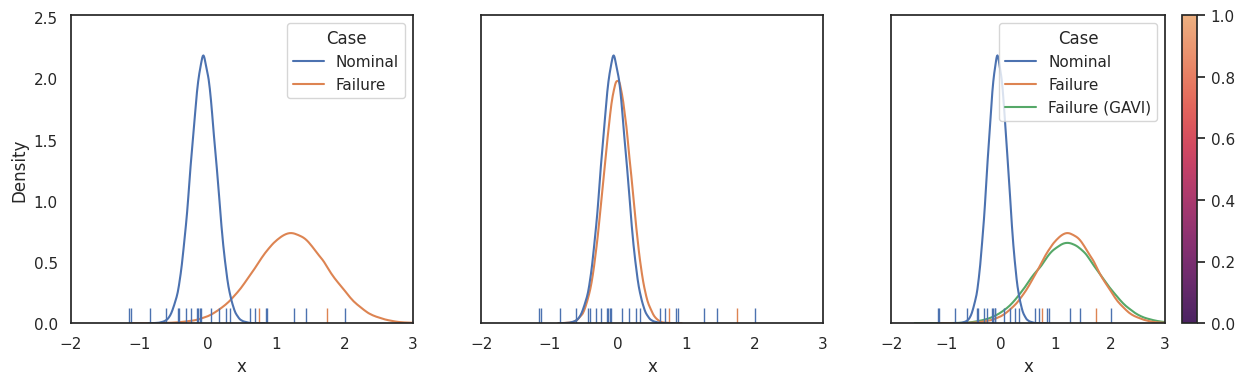

In [229]:
fig, axs = plt.subplot_mosaic(
    [["failure_only", "all_data", "gavi"]], figsize=(15, 4), sharey=True
)

sns.kdeplot(data=failure_only_posterior_df, x="x", hue="Case", ax=axs["failure_only"], common_norm=False)
sns.kdeplot(data=all_posterior_df, x="x", hue="Case", ax=axs["all_data"], legend=False, common_norm=False)
# sns.kdeplot(
#     data=gavi_posterior_df,
#     x="x",
#     hue="$\lambda$",
#     ax=axs["gavi"],
#     legend=False,
#     palette="flare_r",
#     common_norm=False,
# )
sns.kdeplot(
    data=gavi_posterior_df,
    x="x",
    hue="Case",
    ax=axs["gavi"],
    legend=True,
    common_norm=False,
)


# Add a colorbar for graduations
norm = plt.Normalize(min(graduations), max(graduations))
sm = plt.cm.ScalarMappable(cmap="flare_r", norm=norm)
axs["gavi"].figure.colorbar(sm, ax=axs["gavi"])

for ax in axs.values():
    sns.rugplot(x="x", hue="type", data=df, ax=ax, legend=False, height=0.05)
    ax.set_xlim([-2, 3])

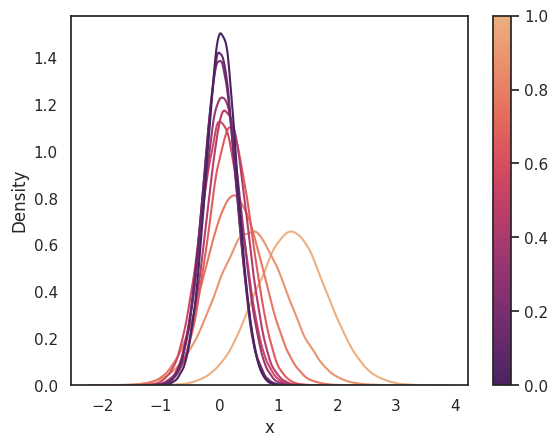

In [226]:
ax = sns.kdeplot(
    data=gavi_posterior_df,
    x="x",
    hue="$\lambda$",
    legend=False,
    palette="flare_r",
    common_norm=False,
)

# Add a colorbar for graduations
norm = plt.Normalize(min(graduations), max(graduations))
sm = plt.cm.ScalarMappable(cmap="flare_r", norm=norm)
ax.figure.colorbar(sm, ax=ax)